# Imports and Google Drive Mount

This code must be pasted along with the primary/baseline models to create the train-test-splits

All notebooks are meant to be ran on Google Colab, but can be easily changed for a local machine.

In [ ]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
import torch.backends.cudnn as cudnn
from torchvision import transforms

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-dc86b91d-bcea-4783-7cfd-99adbf35ce4d)


# Data Processing

## Data Transforms and Split

In [ ]:
main = '/content/gdrive/MyDrive/APS360 Project'

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomCrop((125, 125)),
    transforms.RandomRotation(degrees=45),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.05),
    transforms.RandomResizedCrop(size=150, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 70-15-15 split
dataset = torchvision.datasets.ImageFolder(main + '/aps360_project_dataset', transform=transform)

train_size = int(0.7 * len(dataset))
test_size = int(0.15 * len(dataset)) + 1
val_size = int(0.15 * len(dataset))

print(len(dataset))
print(train_size, val_size, test_size)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])


29034
20323 4355 4356


## Weighted Oversampling using Image Augmentation

In [ ]:
# With Augmentation
transform_train_subset = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomCrop((125, 125)),
    transforms.RandomRotation(degrees=45),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.05),
    transforms.RandomResizedCrop(size=150, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# calculate the number of examples to sample from each class
class_indices = np.array([1831, 1701, 3614, 3732, 3780, 3664, 2001])
max_class_size = 3780
class_weights = [(3780 / class_indices[c]) for c in range(7)]
num_samples = [int(class_weights[c] * class_indices[c]) for c in range(7)]

#for easier access simply copy paste the weights from sample_weights.txt as this loop will take a while to run
sample_weights = np.zeros(len(train_dataset))
sample_weights = [class_weights[label] for _, label in train_dataset]
for idx, (tensor, label) in enumerate(train_dataset):
    class_weight = class_weights[label]
    sample_weights[idx] = class_weight

# create a WeightedRandomSampler to oversample the training set
sampler = data.WeightedRandomSampler(weights=sample_weights, num_samples=sum(num_samples), replacement=True)

# create new training set with oversampled examples
oversampled_train_dataset = data.Subset(train_dataset, indices=list(sampler))

# Sampling the subset
oversampled_train_dataset.transform = transform_train_subset

print(len(oversampled_train_dataset), len(train_dataset))

[2.0644456581103223, 2.2222222222222223, 1.0459324847814055, 1.0128617363344052, 1.0, 1.0316593886462881, 1.8890554722638682]
[3780, 3780, 3779, 3780, 3780, 3779, 3780]
26458 20323


## Count num samples per class

In [ ]:
from collections import Counter

class_counts = Counter()
#replace val_dataset with entire dataset, train, or test
for i in range(len(val_dataset)):
    _, label = val_dataset[i] # assuming the subset consists of (data, label) pairs
    class_counts[label] += 1

print(class_counts)

{'buildings': 5256, 'desert': 4800, 'forest': 5145, 'glacier': 5357, 'mountain': 5437, 'sea': 5184, 'street': 5766}


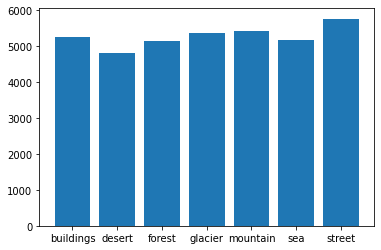

In [ ]:
# Convert dataset.targets to a PyTorch tensor
targets = torch.tensor(dataset.targets)

# Create a dictionary to store the number of images per class
num_images = {}

# Loop through each class and count the number of images
for class_idx in range(len(dataset.classes)):
    class_name = dataset.classes[class_idx]
    num_images[class_name] = (targets == class_idx).sum().item()

print(num_images)

# Plot the number of images per class
plt.bar(range(len(num_images)), list(num_images.values()))
plt.xticks(range(len(num_images)), list(num_images.keys()))
plt.show()